A notebook demonstrating the estimation of groundwater quality for the Keep River planes aquifer system. We determine that there is a strong linear relationship between groundwater EC (measured from pore fluid samples) and the representative bulk AEM conductivity. We use this empirical relationship to estimate the groundwater quality for the top 

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import rasterio
from sqlite3 import dbapi2 as sqlite
import numpy as np
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, borehole_utils, grid_utils
from shapely.geometry import Polygon, shape
import netCDF4
import math
import time
import os, glob
import gc
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from geophys_utils import points2convex_hull
import rasterio
from rasterio import Affine
from rasterio.warp import reproject, Resampling
from scipy import interpolate, stats
import sqlalchemy as db
from sqlalchemy import create_engine, event
import matplotlib.pyplot as plt
from hydrogeol_utils.db_utils import makeCon, closeCon

In [3]:
def resample_raster2array(infile, newaff, new_shape, driver='GTiff',
                    null = -999):

    # Open
    src = rasterio.open(infile)

    # Extract data as an array
    arr = src.read()[0]

    # Get the affine
    aff = src.transform


    # Create new array with the grid
    # coordinates from the kriging
    newarr = np.empty(shape=new_shape)

    # Reproject
    reproject(
        arr, newarr,
        src_transform=aff,
        dst_transform=newaff,
        src_crs=src.crs,
        dst_crs=src.crs,
        resampling=Resampling.bilinear)

    src.close()

    # This is a hack to handle different nulls which are always lower than -900
    
    newarr[newarr < -900] = np.nan

    return newarr

def slice_conductivity(logcondprofile, cond_intervals, base, top):
    old_intervals = cond_intervals.copy()
    
    old_intervals[:,0]= old_intervals[:,0] + 0.01

    old_intervals = np.sort(old_intervals.flatten())
    
    # repeat params
    params = np.repeat(logcondprofile, 2)
    
    # Interpolate

    f = interpolate.interp1d(old_intervals,
                             params, kind='linear')
    
    new_intervals = np.array([top,base])
    
    xnew = new_intervals
    
    xnew = xnew[(xnew > np.min(old_intervals)) & (xnew < np.max(old_intervals))]

    xnew = np.sort(np.concatenate((old_intervals, xnew)))

    ynew = f(xnew)
    mask = np.logical_and(xnew <= base, xnew >= top)
    
    new_profile = ynew[mask]
    new_depths = xnew[mask]
    
    # Calculate thickness
    thickness = spatial_functions.depth_to_thickness(new_depths)[:-1]
    # Calculate weights based on thickness
    weights = thickness/(thickness.sum())
    
    # Now multiply these weights by the profile
    weighted_logcond = weights * new_profile[:-1]
    
    return(np.sum(weighted_logcond))
    
# Function for finding the nearest point 

def get_bore(df, borehole_id):
    """
    df: dataframe with borehole data
    borehole_id: eno
    
    returns
    dataframe with only rows corresponding to particular bore
    """
    mask = df['borehole_id'] == borehole_id
    return df[mask]


In [4]:
# Bring in the AEM

nc_dir = r"C:\Users\PCUser\Desktop\EK_data\AEM\netCDF"

cond_path = os.path.join(nc_dir,'EastKimberley_wb_inversion.nc')
cond_dataset = netCDF4.Dataset(cond_path, 'r')

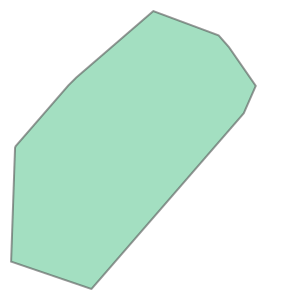

In [5]:
# Create a convex hull around the Keep River area based on line 3xxx,xxx

# Initialise an instance of the netCDF point and line utility classes
cond_line_utils = NetCDFLineUtils(cond_dataset)
cond_point_utils = NetCDFPointUtils(cond_dataset)

# Display the lines for the conductivity mode

lines = cond_line_utils.line

# Get the utm coordinates using the mask created above
utm_wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)

# Get the convex hull of the subset
convex_hull = points2convex_hull(aem_coords)


# Create a shapely object of the convex hull
Keep_poly = Polygon(convex_hull)

Keep_poly

In [6]:
# Extract data from the database

# Extract borehole data from the database

DB_PATH = r"C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite"

SPATIALITE_PATH = r'C:\mod_spatialite-NG-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)


connection = makeCon(DB_PATH)

Connected to C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite. Temporary working copy created.


In [7]:
# Extract boreholes from within this geometry

df_header = borehole_utils.extract_boreholes_within_geometry('borehole', connection,
                                                             Keep_poly.wkt, columns = 'all',
                                                             verbose = True)
# Keep only bores with both EC

mask = df_header['Induction_acquired'] == 1

df_header= df_header[mask]

# Get the enos

enos= df_header['borehole_id'].values

Select b.* from borehole b  where within(b.geom,GeomFromText('POLYGON ((497703.0000000027 8246242.49994433, 497669.0000000026 8246242.99994433, 497635.8125000035 8246246.49994433, 497603.4062500036 8246253.999944331, 496786.3125000036 8246526.499944339, 464605.5000000424 8257490.999944661, 466221.6875000397 8304389.499946042, 466469.6875000387 8305081.999946062, 488233.6875000138 8330164.999946804, 491461.4062500101 8333382.4999469, 523230.3124999756 8360782.999947714, 550185.3749999455 8350756.499947417, 554398.812499941 8345955.999947274, 565480.3749999278 8329967.999946802, 565481.374999927 8329943.4999468, 560532.9999999315 8318658.499946466, 497768.9062499999 8246255.499944331, 497736.5937500015 8246246.49994433, 497703.0000000027 8246242.49994433))'));


In [8]:
# First import all the datasets based on our enos (primary key)

df_EC = borehole_utils.extract_sql_with_primary_key("pore_fluid_EC_pH", 
                                                       ['Depth', 'EC', 'borehole_id'],
                                                       connection, enos, verbose = True)


select t.Depth, t.EC, t.borehole_id from pore_fluid_EC_pH t where t.borehole_id in (626981,626984,626986,626987,626988,626989,626990,626991,626992,635728,635729,635730,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635744,635745,635746,635921,635957,635958,635959,635960,636181,636182,636183,636184,636185,636186,636189,636190,636191,636193,636194,636195,636196,636197,636198,636200,636201,636204);


In [9]:
# Get bulk the representative AEM conductivity profiles using a nearest neighboour search

cond_point_utils = NetCDFPointUtils(cond_dataset)

utm_wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)

# Extract the AEM conductivity using nearest neighbour
distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']],
                                                          aem_coords,
                                                          points_required = 1,# return 1 closest point
                                                          max_distance = 250.)
# Remove nulls which are >250m from a FID
mask = np.isfinite(distances)

indices = indices[mask]
df_header = df_header[mask]

In [10]:
# Extract variables as arrays using the index mask
conductivity_profile = cond_dataset['conductivity'][indices]

depth_tops = cond_dataset['layer_top_depth'][indices]

depth_bottom = np.nan*np.ones(depth_tops.shape, dtype = np.float32)

depth_bottom[:,:-1] = depth_tops[:,1:]

east = cond_dataset['easting'][indices]
north = cond_dataset['northing'][indices]
doi = cond_dataset['depth_of_investigation'][indices]

In [11]:
# Create an AEM dataframe

df_AEM = pd.DataFrame(columns = ['Depth_from', 'Depth_to',
                                 'conductivity', 'easting',
                                 'northing', 'borehole_id', 'EC',
                                 'doi'])

df_AEM['conductivity'] = conductivity_profile.flatten()
df_AEM['Depth_from'] = depth_tops.flatten()
df_AEM['Depth_to'] = depth_bottom.flatten()

df_AEM['easting'] = np.repeat(east, conductivity_profile.shape[1])
df_AEM['northing'] = np.repeat(north, conductivity_profile.shape[1])

df_AEM['doi'] = np.repeat(doi, conductivity_profile.shape[1])

df_AEM['borehole_id'] = np.repeat(df_header['borehole_id'].values,
                                   conductivity_profile.shape[1])

In [12]:
# Mask below the doi

mask = df_AEM['doi'] > df_AEM['Depth_from']

df_AEM = df_AEM[mask]

In [13]:
# Now we iterate through each AEM layer and find the median EC

for bore in df_AEM['borehole_id'].unique():
    
    df_EC_subset = get_bore(df_EC, bore)
    
    df_AEM_subset = get_bore(df_AEM, bore)
    
    new_intervals = df_AEM_subset[['Depth_from', 'Depth_to']]
    
    # interpolate
    df_newEC = spatial_functions.interpolate_depths_to_intervals(df_EC_subset, ['EC'],
                                                                 new_intervals.values,
                                                                depth_column='Depth', how='median')

    df_AEM_subset['EC'] = df_newEC['EC'].values
    
    df_AEM.at[df_AEM_subset.index, :] = df_AEM_subset
    
    
df_AEM.dropna(how = 'any', subset = ['EC'], inplace=True)

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [14]:
# Linear regression function

from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(df_AEM['conductivity'].values),
                                                               np.log10(df_AEM['EC'].astype(np.float).values))

R-squared =  0.8730838897685248
EC =  0.9113338790415202  * sigma +  0.5156731346597092


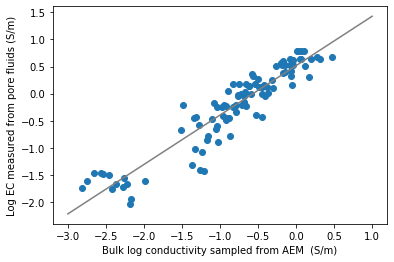

In [23]:
# Scatter plot the EC and apparent conductivity

x = np.array([-3,1])
y = slope * x + intercept

fig, ax = plt.subplots(1,1, figsize = (6,4))
ax.plot(x, y, 'gray')

ax.scatter(np.log10(df_AEM['conductivity'].values),
           np.log10(df_AEM['EC'].astype(np.float).values))
           #c = df_EC_cond['Depth'].values,
           #colormap='viridis')
print('R-squared = ', str(r_value**2))
print('EC = ', str(slope), ' * sigma + ', str(intercept) )

        
ax.set_xlabel('Bulk log conductivity sampled from AEM  (S/m)')

ax.set_ylabel('Log EC measured from pore fluids (S/m)')

plt.savefig(r'C:\Users\PCUser\Desktop\EK_data\Interp\EK_saturated_EC_AEM_conductivity_scatter.png', dpi = 300)
plt.show()

In [17]:
# Now we have our function we want to find the average AEM
# conductivity for the top 20m of saturated aquifer

# bring in the water table surface

wt_infile = r"C:\Users\PCUser\Desktop\EK_data\Interp\WaterTable\KR_wt_depth_clipped.tif"

wt_src = rasterio.open(wt_infile)
wt_arr = wt_src.read()[0]

# Romve null values

null = -3.4028235e+38

wt_arr[np.isclose(wt_arr, null)] = np.nan

# Now we want the base of our volume to be 20 deeper than the water table depth

base_arr = wt_arr + 20.

In [19]:
# Create a grid onto which we will be interpolating our AEM conductivity

nrow, ncol = wt_arr.shape[0], wt_arr.shape[1]

xr, yr = np.abs(wt_src.transform.a), np.abs(wt_src.transform.e)

# Get the lower left coordinates for x and y-offset inputs into grid
xoff = wt_src.bounds.left
yoff = wt_src.bounds.bottom

# Create a structured grid
sat_grid = grid_utils.StructuredGrid(delr = np.array(ncol * [yr]),
                                    delc = np.array(nrow * [xr]),
                                    top=wt_arr,#
                                    botm=np.expand_dims(base_arr, axis=0),
                                    proj4=wt_src.crs.to_proj4(),
                                    xoff = xoff,
                                    yoff = yoff,
                                    nlay = 1,
                                    lenuni=2, # units are metres
                                    nrow= nrow,
                                    ncol = ncol
                                    )

minx, maxx, miny, maxy = sat_grid.extent

In [20]:
# Find the depth indices to interpolate
max_depth = np.nanmax(base_arr)

max_ind = np.where(cond_dataset['layer_top_depth'][0] < max_depth)[0].max() + 1

In [21]:
# Define gdal algorithm as string - see https://gdal.org/programs/gdal_grid.html
algorithm = 'invdist:power=2:radius1=250:radius2=250:max_points=10:'
algorithm += 'min_points=2:nodata=-9999.99'

grid_kwargs = {'conductivity': {'log_grid': True,
                                'gdal_algorithm': algorithm}}

start_time = time.time()

# Currently this is too resource intense, need to make it more effecient
aem_grid = spatial_functions.grid_points_gdal(cond_point_utils,
                 grid_resolution = xr,
                 variables = 'conductivity',
                 reprojected_grid_bounds = (minx, miny, maxx, maxy),
                 grid_wkt = utm_wkt,
                 point_step=1,
                 grid_kwargs = grid_kwargs,
                 depth_inds = np.arange(0,max_ind))

print("Gridding time: ", time.time() - start_time, ' seconds')

# Finall we remove the 2 cell buffer and flip up down

aem_grid['conductivity'] = aem_grid['conductivity'][:,2:-2,2:-2][:,::-1,:]

Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding time:  221.62178564071655  seconds


c:\users\pcuser\onedrive\github\hydrogeol_utils\hydrogeol_utils\spatial_functions.py:738: RuntimeWarning: invalid value encountered in greater_equal
  mask = np.greater_equal(depth_top, layer_top_depth)
c:\users\pcuser\onedrive\github\hydrogeol_utils\hydrogeol_utils\spatial_functions.py:739: RuntimeWarning: invalid value encountered in less_equal
  mask += np.less_equal(depth_bottom,layer_bottom_depth)


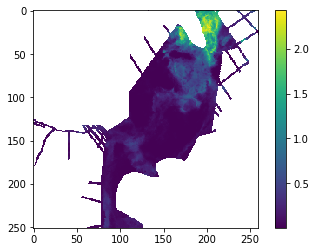

In [23]:
# Now lets calculate the weighted average of the AEM between the wt top and 20m below

wt_ave_grid = spatial_functions.weighted_average(cond_dataset['layer_top_depth'][0],
                                np.log10(aem_grid['conductivity']),
                               wt_arr, base_arr)
# Convert back to linear space
wt_ave_grid = 10**(wt_ave_grid)

# Plot the result


plt.imshow(wt_ave_grid)
plt.colorbar()
plt.show()


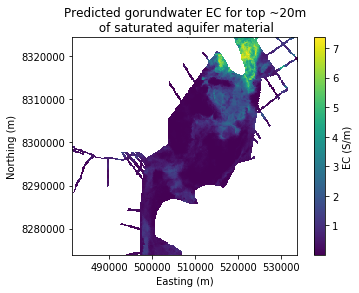

In [28]:
# The final step is to apply the linear regression function

gw_logEC = slope * np.log10(wt_ave_grid) + intercept


gw_EC = 10**(gw_logEC)

plt.imshow(gw_EC, extent= [minx, maxx, miny, maxy])
plt.title('Predicted gorundwater EC for top ~20m\n of saturated aquifer material')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cbar = plt.colorbar()
cbar.set_label('EC (S/m)')


outfile = r"C:\Users\PCUser\Desktop\EK_data\Interp\EK_gw_EC_saturated_top_20m.png"
plt.savefig(outfile, dpi= 300)
plt.show()



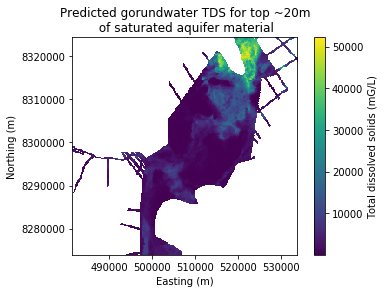

In [30]:
# Calculate the TDS with an empirical conversion factor

gw_TDS = (gw_EC/1.41) * 10000.

plt.imshow(gw_TDS, extent= [minx, maxx, miny, maxy])
plt.title('Predicted gorundwater TDS for top ~20m\n of saturated aquifer material')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cbar = plt.colorbar()
cbar.set_label('Total dissolved solids (mG/L)')


outfile = r"C:\Users\PCUser\Desktop\EK_data\Interp\EK_gw_TDS_saturated_top_20m.png"
plt.savefig(outfile, dpi= 300)
plt.show()

In [31]:
# Save the outfile

null = -9999.

outfile =  r"C:\Users\PCUser\Desktop\EK_data\Interp\EK_gw_EC_saturated_top_20m.tif"

new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                            height= gw_EC.shape[0], width=gw_EC.shape[1],
                            count=1, dtype=np.float64,
                            crs=wt_src.crs, transform=wt_src.transform,
                            no_data = null)

# set nan to no data value
gw_EC[np.isnan(gw_EC)] = null

new_dataset.write(gw_EC, 1)

new_dataset.close()
    


outfile =  r"C:\Users\PCUser\Desktop\EK_data\Interp\EK_gw_TDS_saturated_top_20m.tif"
    
new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                            height= gw_EC.shape[0], width=gw_EC.shape[1],
                            count=1, dtype=np.float64,
                            crs=wt_src.crs, transform=wt_src.transform)

# set nan to no data value
gw_TDS[np.isnan(gw_TDS)] = null

new_dataset.write(gw_TDS, 1)

new_dataset.close()